# 수화 이미지 분류 경진대회

## 패키지 import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import re
import os
import warnings
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings(action = 'ignore')

In [3]:
os.chdir('C:/Users/Jaesu/Dacon-Basic/수화이미지-분류')

In [4]:
SEED = 22
N_FOLD = 10
SAVE_PATH = './weight'
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 16

In [5]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  858 non-null    object
 1   label      858 non-null    object
dtypes: object(2)
memory usage: 13.5+ KB


`-` 결측치는 없다

In [270]:
df.head()

,file_name,label
0,001.png,10-2
1,002.png,10-1
2,003.png,3
3,004.png,8
4,005.png,9


`-` 파일 이름과 라벨명이 한 쌍으로 되어있음

## 이미지 시각화

In [20]:
order = list(map(str, range(1, 10))) + ['10-1', '10-2']

<AxesSubplot:xlabel='label', ylabel='count'>

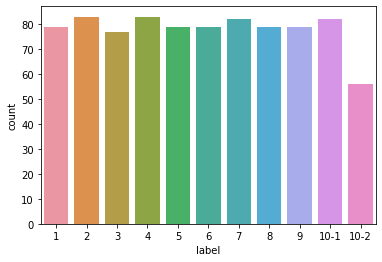

In [22]:
sns.countplot(data=df, x='label', order=order)

`-` 10-2를 제외하면 클래스가 균등하게 분포하고 있음

In [260]:
def load_images(path):
    images = []
    for img in sorted(glob(path + '/*.png')): ## path에 들어있는 png 파일을 검색(1번부터 차례대로 검색해야 된다)
        an_img = PIL.Image.open(img)  
        img_array = np.array(an_img)  
        images.append(img_array)  
            
    images = np.array(images)
    return images

In [285]:
train_images = load_images(path='./Data/train')

In [286]:
test_images = load_images(path='./Data/test')

In [287]:
train_images.shape

(858, 224, 224, 3)

In [146]:
def show_images(images: np.array, labels: np.array, nrows: int = 3, ncols: int = 3) -> None:
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*2, ncols*2))
    nums = list(map(int, np.random.uniform(size=nrows*ncols) * images.shape[0]))
    
    for i, ax in enumerate(axs.flatten()):
        num = nums[i]
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(labels[num])
        ax.imshow(images[num])
    fig.tight_layout()

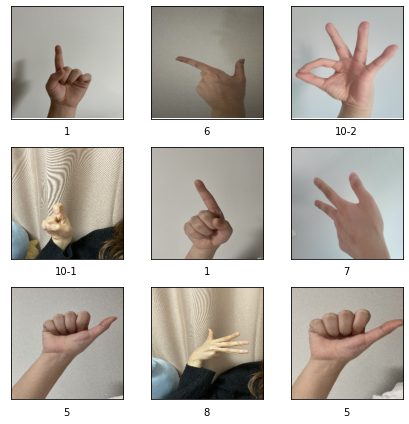

In [176]:
show_images(train_images, np.array(df['label']))

`-` 라벨별로 이미지를 시각화하자

- `수화 1`

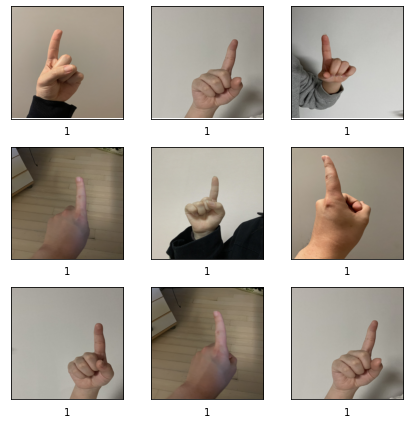

In [177]:
show_images(train_images[df.query('label == "1"').index], ['1']*1000) ## 라벨은 어차피 '1'만을 값으로 가져서 길이 상관 X, images 개수보다 많기만 하면 된다)

- `수화 2`

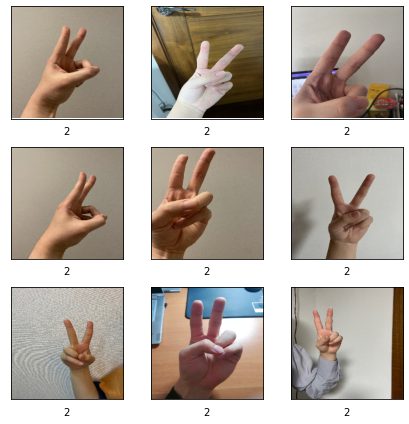

In [178]:
show_images(train_images[df.query('label == "2"').index], ['2']*1000)

- `수화 3`

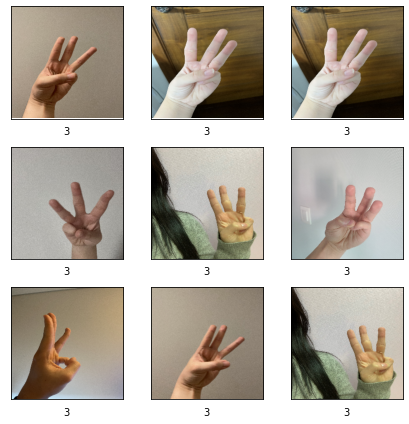

In [179]:
show_images(train_images[df.query('label == "3"').index], ['3']*1000) 

- `수화 4`

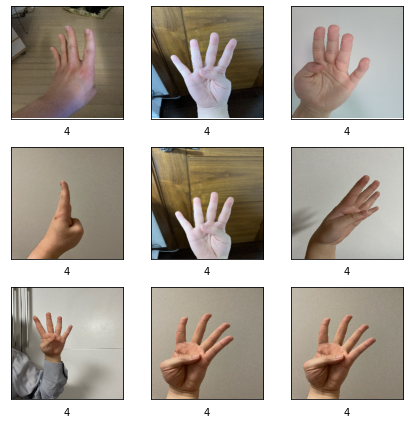

In [180]:
show_images(train_images[df.query('label == "4"').index], ['4']*1000)

- `수화 5`

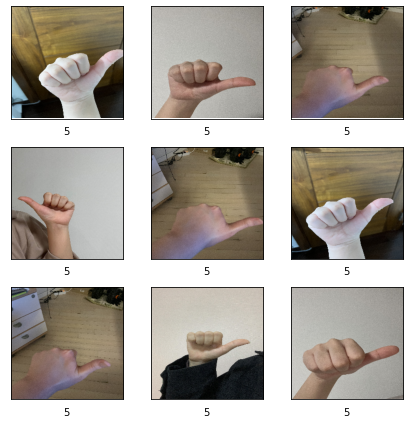

In [181]:
show_images(train_images[df.query('label == "5"').index], ['5']*1000) 

- `수화 6`

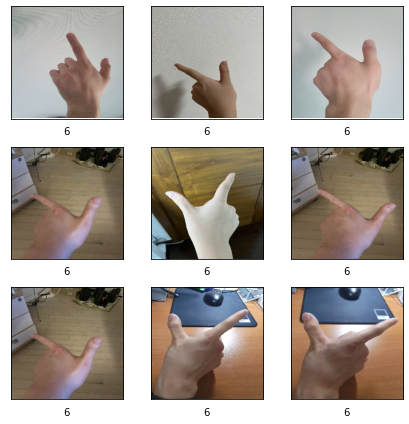

In [191]:
show_images(train_images[df.query('label == "6"').index], ['6']*1000) 

- `수화 7`

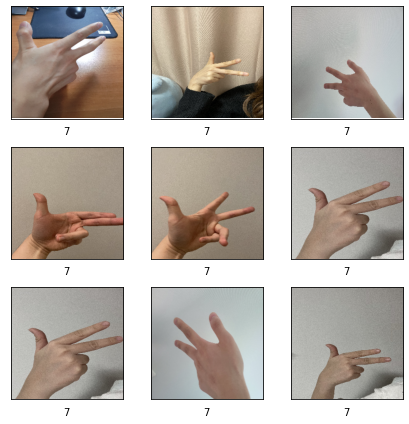

In [183]:
show_images(train_images[df.query('label == "7"').index], ['7']*1000) 

- `수화 8`

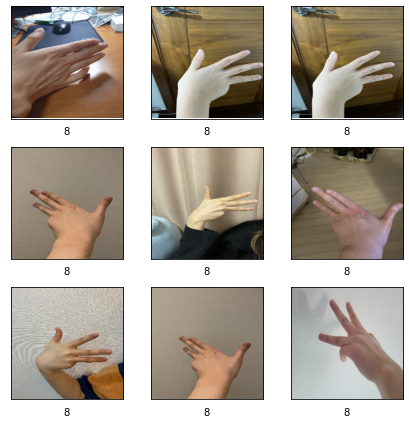

In [184]:
show_images(train_images[df.query('label == "8"').index], ['8']*1000) 

- `수화 9`

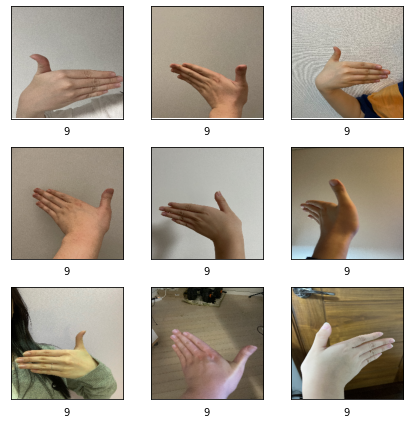

In [185]:
show_images(train_images[df.query('label == "9"').index], ['9']*1000) 

- `수화 10-1`

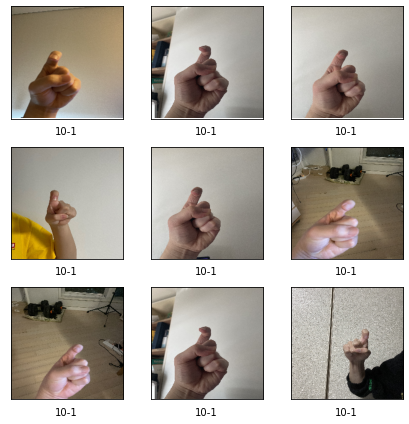

In [186]:
show_images(train_images[df.query('label == "10-1"').index], ['10-1']*1000) 

- `수화 10-2`

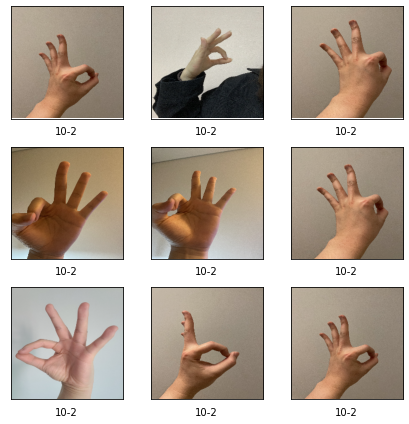

In [187]:
show_images(train_images[df.query('label == "10-2"').index], ['10-2']*1000) 

- 정리 

`-` 이미지들을 보면 같은 사람이 찍은 사진이 보인다

`-` 한 명당 `1 ~ 10-2` 수화까지 여러장 찍은 듯 하다

`-` 같은 사람이 찍은 사진은 거의 똑같이 보인다(아주 살짝만 다름)

`-` 다른 사람끼리는 조금 다른 경우가 있고 많이 다른 경우가 있다

`-` 많이 다른 경우: 왼손잡이와 오른손잡이

`-` 조금 다른 경우: 왼손과 왼손, 오른손과 오른손, 그런데 이제 각도가 다름

`-` 왼손잡이와 오른손잡이의 격차를 완화: `Horizontal Flip`

`-` 이미지를 잘 보면 위쪽 영역은 수화와 관련되어있지 않다(아래쪽에서부터 손목이 등장)

`-` 그리고 사실 손목도 수화를 해석하는데 필요없다(중앙부분만 필요)

`-` 사람끼리의 수화 이미지 차이를 완화: `GaussianBlur, Rotate, CenterCrop` 등등(유효한 것만 사용)

## 데이터 셋 및 딥러닝 모델 정의

In [203]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms, models
import gc

In [194]:
## accuracy 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

In [195]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [196]:
print(f'현재 device는 {device}입니다')

현재 device는 cpu입니다


In [197]:
def seed_everything(seed: int = 22):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [198]:
seed_everything(SEED) ## 재현을 위한 seed 고정

- 이미지 경로

In [290]:
train_img_path_list = glob('./Data/train/*.png')
test_img_path_list = glob('./Data/test/*.png')

- 데이터 셋과 데이터 로더

In [408]:
class CustomDataset(Dataset):
  
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        self.train_mode = train_mode
    
    def __getitem__(self, idx):
        img_path = self.img_path_list[idx]
        image = PIL.Image.open(img_path)
        image = np.array(image)
        
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[idx]
            return image, label
        
        return image ## test는 라벨이 없다
    
    def __len__(self):
        return len(self.img_path_list) ## 데이터 개수 반환

`-` 신기한 것 발견: `np.array(np.array)`를 실행하면 에러가 안난다...

- 데이터 변환

In [227]:
RGB_MEAN = [np.mean((train_images[..., i] / 255)) for i in range(3)] ## 255로 나눈후 RGB 각각의 평균
RGB_STD = [np.std(train_images[..., i] / 255) for i in range(3)]  ## 255로 나눈후 RGB 각각의 표준편차

In [234]:
## 데이터 변환 방식을 정의(Agumentation)
def get_transform(train_mode=True):
    trans = transforms.Compose([
        transforms.ToTensor(), ## PIL or numpy array(H X W X C; 0 ~ 255) -> torch tensor(H X W X C; 0 ~ 1)
        transforms.Normalize(RGB_MEAN, RGB_STD) ## 평균을 0, 표준편차를 1로 만듦
    ])
    
    if train_mode:
        trans = transforms.Compose([
            transforms.ToPILImage(), ## numpy array(H X W X C)를 PIL이미지로 바꾼다
            transforms.CenterCrop(size=196), ## size X size 크기의 이미지를 중앙에서 crop
            transforms.transforms.GaussianBlur(kernel_size=(5, 5)),
            transforms.RandomHorizontalFlip(p=0.5), ## 50%의 확률로 수평으로 뒤집음
            transforms.RandomRotation(degrees=10), ## 무작위로 -degrees~degrees 각도 회전
            transforms.ToTensor(), ## PIL or numpy array(H X W X C; 0 ~ 255) -> torch tensor(H X W X C; 0 ~ 1)
            transforms.Normalize(mean=RGB_MEAN, std=RGB_STD) ## 평균을 0, 표준편차를 1로 만듦
        ])

    return trans ## 데이터 변환 방식을 반환

`-` 라벨을 `0~10`로 변환하겠다

In [317]:
def get_label_map() -> dict:
    label_map = dict()
    label_map['10-1'] = 10
    label_map['10-2'] = 0
    for i in range(1, 10):
        label_map[str(i)] = i

    return label_map

In [327]:
def label_encoding_transform(label: pd.Series) -> pd.Series:
    label_map = get_label_map()
    encoded_label = label.apply(lambda x: label_map[x])
    return encoded_label

In [345]:
def label_encoding_inverse_transform(encoded_label: pd.Series) -> pd.Series:
    label_map = get_label_map()
    label_inverse_map = dict(zip(label_map.values(), label_map.keys()))
    label = encoded_label.apply(lambda x: label_inverse_map[x])
    return label

In [348]:
target = label_encoding_transform(df['label'])

- CNN 신경망

`-` `resnet18` 사용

In [360]:
class Resnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=False) ## Resnet18 아키텍쳐사용
        #self.drop = nn.Dropout(0.2)
        self.fc = nn.Linear(1000, 11) ## resnet18의 최종 output차원은 1000 
        
    def forward(self, x):
        x = self.resnet(x)
        #x = self.drop(x)
        x = self.fc(x)
        return x

- Linear layer 가중치 초기화

In [229]:
## Linear layer 가중치 초기화
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        m.weight.data.normal_(0.0, 1/np.sqrt(y))
        m.bias.data.fill_(0)

- 조기 중단

In [1]:
class EarlyStopping:
    ## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', n_fold=1):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 에폭
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint 저장 경로
                            Default: 'checkpoint.pt'
            n_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = None
        self.delta = delta
        self.path = path
        self.n_fold = n_fold

    def __call__(self, model, val_loss, val_acc):

        score = -val_loss ## val_loss는 작을수록 좋다 ## score는 0에 가까울수록 좋다

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, model)  
        elif score < self.best_score + self.delta: ## loss가 개선되지 않았을 때
            self.counter += 1 ## 카운팅 +1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: ## 만약 loss가 개선되지 않은 스탭이 patience보다 크거나 같아진다면 조기중단
                self.early_stop = True
        else: ## loss가 개선됨
            self.best_score = score ## score 갱신
            self.save_checkpoint(val_loss, val_acc, model) ## loss와 model 저장
            self.counter = 0 ## loss가 개선되었으므로 0으로 초기화

    def save_checkpoint(self, val_loss, val_acc, model):
        """validation loss가 감소하면 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f})  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/best_{self.n_fold}.pt') ## 모델의 계층별 가중치를 지정한 경로에 저장
        self.val_loss_min = val_loss ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.val_acc = val_acc ## 이때의 valid accuracy도 변경해준다

## 모델 교차검증

In [361]:
skfold = StratifiedKFold(n_splits=N_FOLD, random_state=SEED, shuffle=True) ## k겹 교차검증

In [362]:
loss_fn = torch.nn.CrossEntropyLoss()   ## 손실 함수에 소프트맥스 함수 포함 -> net 내부에서 마지막 활성화함수로 소프트맥스 사용안해도 됨

In [363]:
def train(model: nn.Module, dataloader, optimizer, loss_fn, scheduler=None):
    """dataloader의 데이터를 사용하여 학습된 모델과 평균 훈련 오차를 반환"""
    model.train() ## 훈련모드
    train_avg_loss = 0 ## 에폭별 배치단위 평균 훈련 오차
    train_total_batch = len(dataloader) ## 배치 크기

    for X, y in dataloader: ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad() ## 그래디언트 초기화
        yhat = model(X) ## y_hat을 구한다
        loss = loss_fn(yhat, y).to(device) ## 오차를 계산 ## train loss
        loss.backward()  ## 미분
        optimizer.step() ## 업데이트
        train_avg_loss += (loss.item() / train_total_batch) ## 각 배치마다 훈련 오차 누적

    ## epoch마다 학습률 조절
    if scheduler is not None:
        scheduler.step()

    return model, train_avg_loss

In [364]:
def evaluate(model: nn.Module, dataloader, loss_fn):
    """dataloader의 데이터를 사용하여 모델에 대한 평균 평가 오차와 평가 정확도를 반환"""
    valid_avg_acc, valid_avg_loss = 0, 0

    model.eval() ## 평가모드
    with torch.no_grad(): ## 평가할 땐 역전파를 쓸 필요가 없으니까
        for X, y in dataloader: 
            X, y = X.to(device), y.to(device)
            yhat = model(X)
            loss = loss_fn(yhat, y) ## valid loss
            acc = accuracy(y.cpu().data.numpy(), yhat.cpu().data.numpy().argmax(-1))       
            valid_avg_acc += (acc * len(y) / len(dataloader.dataset)) ## 각 배치마다 정확도(정답 개수 / 전체 개수)
            valid_avg_loss += loss.item() / len(dataloader) ## 각 배치마다 평가 오차 누적    

    return valid_avg_loss, valid_avg_acc

In [411]:
# net_acc = [] ## fold별 valid셋의 평균 정확도
# net_loss = [] ## fold별 valid셋의 평균 손실

# for i, (train_idx, valid_idx) in enumerate(skfold.split(train_img_path_list, target)):
#     gc.collect()
#     torch.cuda.empty_cache()
#     print(f'{i + 1} Fold Training......')
    
#     train_img_path_array = np.array(train_img_path_list)
#     X_train, X_valid = train_img_path_array[train_idx], train_img_path_array[valid_idx] 
#     y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]
#     y_train = torch.tensor(y_train.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
#     y_valid = torch.tensor(y_valid.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    
#     ## early stopping
#     early_stopping = EarlyStopping(patience=10,
#                                    verbose=False,
#                                    path=SAVE_PATH,
#                                    n_fold=i+1) ## patience 횟수 에폭후에도 valid loss가 작아지지 않으면 조기 중단
    
#     ## Linear 모델
#     net = Resnet().to(device)
#     net.apply(init_weights) ## Linear layer 가중치 초기화
    
#     ## Dataset, Dataloader
#     train_dataset = CustomDataset(X_train, y_train, train_mode=True, transforms=get_transform())
#     valid_dataset = CustomDataset(X_valid, y_valid, train_mode=True, transforms=get_transform(train_mode=False))
    
#     train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#     valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

#     ## optimizer
#     optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE) ## 옵티마이저에 최적화할 파라미터와 학습률 전달
    
#     ## scheduler
#     scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                                  lr_lambda=lambda epoch: 0.95 ** epoch,
#                                                  last_epoch=-1,
#                                                  verbose=False)
    
#     # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-5, last_epoch=-1)
#     # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)
    
#     ## fold별로 모델 학습
#     for epoch in tqdm(range(EPOCHS)): ## (배치사이즈 * 에폭)만큼 훈련시킴
#         net, train_avg_loss = train(net, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
#         valid_avg_loss, valid_avg_acc = evaluate(net, valid_dataloader, loss_fn)  ## 모델 평가

#         if epoch % 5 == 0 or epoch == EPOCHS - 1: 
#             ## 5의 배수값을 가지는 에폭마다 평균 배치 훈련 오차와 평가 오차 출력
#             print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            
#         ## epoch마다 early stopping 실행
#         early_stopping(net, valid_avg_loss, valid_avg_acc) ## __call__ function
#         if early_stopping.early_stop: ## early_stop이 true이면
#             if epoch % 5 != 0 and epoch != EPOCHS - 1:
#                 print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
#             print('Early stopping!')
#             break 

#     net_acc.append(early_stopping.val_acc) ## fold별 loss가 가장 작은 모델의 정확도
#     net_loss.append(early_stopping.val_loss_min) ## fold별 loss가 가장 작은 모델의 손실
    
#     ## fold별 평가 루프 종료시 가장 작은 loss와 이때의 accuracy를 출력
#     print(f'{i + 1} Fold -> Best Valid Loss: {early_stopping.val_loss_min:.4f}  Best Valid Accuracy: {early_stopping.val_acc:.4f}\n\n')
    
# ## 마지막으로 폴드별 가장 loss가 작은 모델들의 평균 정확도와 평균 손실을 출력
# print(f'{skfold.n_splits}Fold Mean Valid Accuracy: {np.mean(net_acc):.4f}')
# print(f'{skfold.n_splits}Fold Mean Valid Loss: {np.mean(net_loss):.4f}')     

## test 예측

`-` softmax function을 취하면 11개의 원소 중 최대값의 인덱스 번호가 최종 예측값이 된다

In [412]:
def predict(model: nn.Module, dataloader, weight_save_path):
    """저장된 모델의 가중치를 불러와서 dataloader의 각 데이터를 예측하여 반환"""
    model = model.to(device)
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), 11)) ## test예측값

    for weight in weight_path_list :
        model.load_state_dict(torch.load(weight))
        model.eval()
        probs = None
        
        with torch.no_grad(): 
            for test_batch in dataloader:
                test_batch = test_batch.to(device)
                outputs = model(test_batch).cpu().numpy()
                if probs is None:
                    probs = outputs
                else:
                    probs = np.concatenate([probs, outputs])

        test_probs += (probs / N_FOLD)

    _, test_preds = torch.max(torch.tensor(test_probs), dim=1) ## 최대값과 인덱스를 반환
    return test_preds  

In [413]:
net = Resnet().to(device)

In [416]:
test_dataset = CustomDataset(img_path_list=test_img_path_list, label_list=None, train_mode=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [417]:
# pred = predict(net, test_dataloader, SAVE_PATH)

In [424]:
# pred = label_encoding_inverse_transform(pd.Series(pred))

In [425]:
# submission['target'] = pred
# submission.head()

In [426]:
# submission.to_csv('./Data/submission.csv', index=False)